In [116]:
import torch 
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [117]:
# Train on GPUs if available 
device_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_cpu = torch.device('cpu')

In [118]:
!git clone https://github.com/mprice747/Autoencoders-Workshop.git

fatal: destination path 'Autoencoders-Workshop' already exists and is not an empty directory.


# Image Search with Autoencoders

In 2015, Pinterest released their visual search service, which allows users to crop items from an image and find similar objects. The feature is detailed in this [article](https://medium.com/@Pinterest_Engineering/introducing-a-new-way-to-visually-search-on-pinterest-67c8284b3684). 

<img src='https://drive.google.com/uc?id=1MmrgtrMTHhqhVfTbOG1Yf2DxHcI3kLpB'> <br>
[Image Source](https://medium.com/@Pinterest_Engineering/introducing-a-new-way-to-visually-search-on-pinterest-67c8284b3684)

For this part of the workshop, we will build a simple version of Pinterest's visual search for fashion items. That is, given a picture of a t-shirt, shoe, etc., our algorithm will recommend similar items to the one the user submitted. For our dataset, we will utilize the Fashion MNIST dataset, which contains 28 x 28 images of various types of clothes. The original purpose of this dataset is to label each item of clothing into a category (pants, sweater, etc.), but we can utilize it for our task instead. Altough the model we will be build will be basic, as the images are extremely low resolution, you will still learn the underyling concepts that power many image ranking systems. 

<img src='https://drive.google.com/uc?id=1YEajQkjzn5otFM303zhljS4wa4cPmFfX'> <br>
[Image Source](https://www.tensorflow.org/datasets/catalog/fashion_mnist)

## Considerations when Working with Complex and High Dimensional Data

For many datasets, utilizing a simple metric, like Euclidean distance, to find similar objects is nonoptimal. There are two primary reasons for this:
<br>

**1. Curse of Dimensionality** <br>
The curse of dimensionality is a phenomenon in machine learning where the performance of an algorithm tends to degrade as the number of variables inputted increases. Many classic machine learning algorithms rely on that observations within the same class should be "closer" together than observations from different classes. However, as the number of dimensions increase, the Euclidean distance between points tends to become more and more similar. To demonstrate this point, we will simulate observations from an *n* dimensional uniform distribution and observe the distances among the points. 

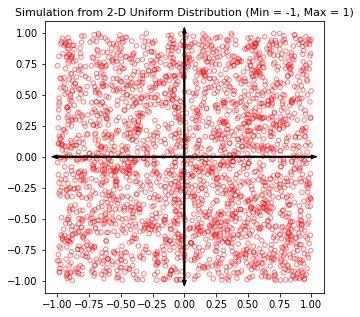

In [119]:
two_dim_uniform = np.random.uniform(low = -1, high = 1, size = (2500, 2))
fig, ax = plt.subplots(figsize = (5, 5))

ax.scatter(two_dim_uniform[:, 0], two_dim_uniform[:, 1], s = 20, alpha = 0.5, facecolors = 'none', edgecolors='r')
ax.arrow(0, 0, 1, 0, width = 0.01, color = 'black')
ax.arrow(0, 0, -1, 0, width = 0.01, color = 'black')
ax.arrow(0, 0, 0, 1, width = 0.01, color = 'black')
ax.arrow(0, 0, 0, -1, width = 0.01, color = 'black')

ax.set_title('Simulation from 2-D Uniform Distribution (Min = -1, Max = 1)', fontsize = 11)
plt.show()

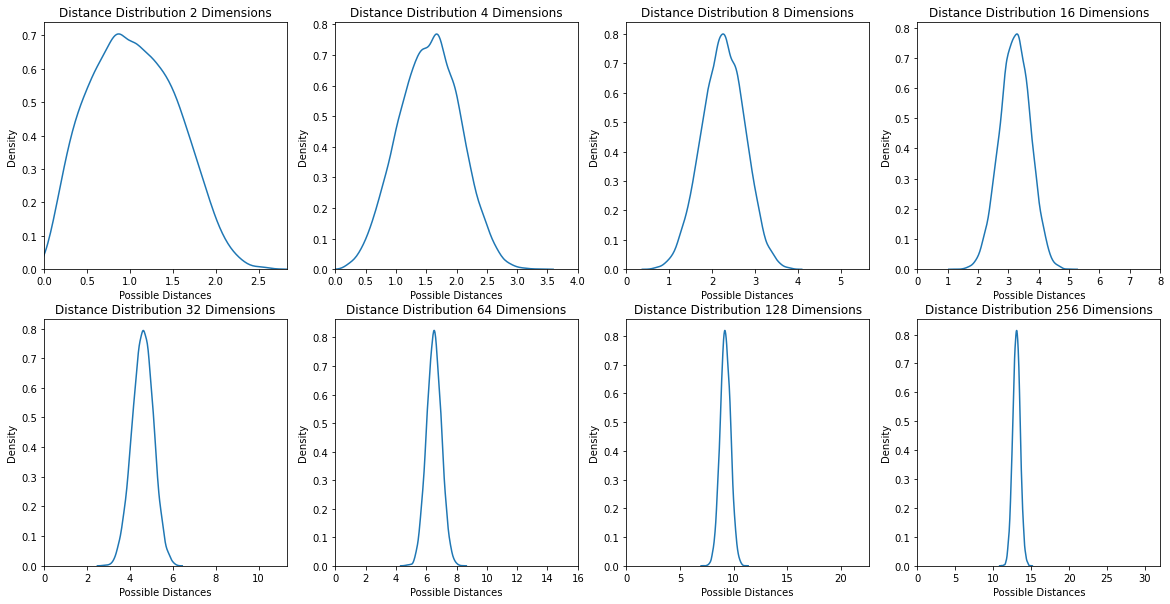

In [120]:
def simulate_uniform_euc_dist(n, dim, low = -1, high = 1):
    '''
    Simulate the distances betwwen random points from an n-dimensional uniform distribution with min = low and max = high
    '''
    distances = np.linalg.norm(np.random.uniform(low, high, (n , dim)) - np.random.uniform(low, high, (n , dim)), axis = 1)
    return distances

fig, ax = plt.subplots(nrows =2, ncols = 4, figsize = (20, 10))
n = 10000

# Simulate distances for 2^(i) dimensions 

for i in range(8):
    
    row_num = i // 4
    col_num = i % 4
    num_dims = 2 ** (i + 1)
    
    distances  = simulate_uniform_euc_dist(n, num_dims)
    
    sns.kdeplot(distances, ax = ax[row_num][col_num])
    ax[row_num][col_num].set_xlim(0, np.sqrt(4 * num_dims))
    ax[row_num][col_num].set_title(f'Distance Distribution {num_dims} Dimensions')
    ax[row_num][col_num].set_xlabel(f'Possible Distances')
    ax[row_num][col_num].set_ylabel(f'Density')

As we increase the dimension, the highest possible distance also increases. However the distances distribution remains concentrated in a much more limited range. Therefore, because of the lack of relatively different distances, machine learning algorithms that rely on Euclidean distance tend to have much lower performance in higher dimensions. <br> <br>

**2 Nonlinearities** <br>

When dealing with complex datasets, like images, the most "similar" object does not necessarily equate to the one "closest" in terms of a simple distance metric. This concern can be best explained with an example. Suppose we want to find the most similar image to the golden bunny compared to the other two. 

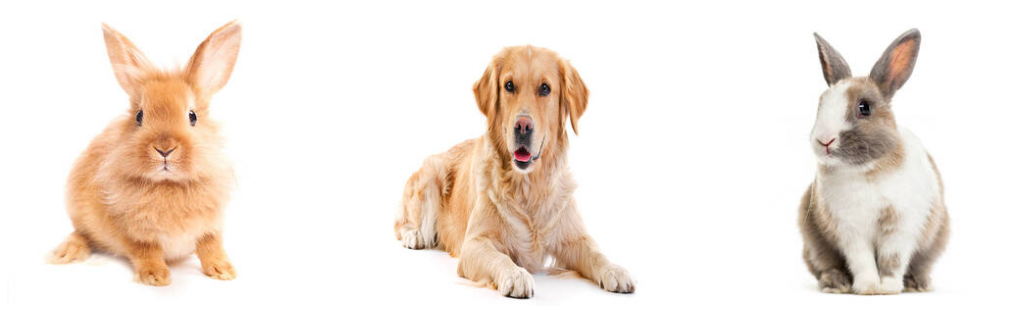

In [121]:
#@title 
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

golden_bunny = mpimg.imread('Autoencoders-Workshop/images/golden_bunny (1).jpeg')
golden_retriever = mpimg.imread('Autoencoders-Workshop/images/golden_retriever (1).jpeg')
b_w_bunny = mpimg.imread('Autoencoders-Workshop/images/brown_and_white_bunny (1).jpeg')

ax[0].imshow(golden_bunny)
ax[0].axis('off')

ax[1].imshow(golden_retriever)
ax[1].axis('off')

ax[2].imshow(b_w_bunny)
ax[2].axis('off')

plt.show()

If we use a simple distance metric like Eucidean distance of the RGB pixel values, not only are the distances to the golden bunny extremely similar (curse of dimensionality!) but the golden retriever is closer to the golden bunny than the actual other bunny! 

In [122]:
print("Golden Bunny Euclidean Distance to Golden Retriever:", np.linalg.norm((golden_bunny - golden_retriever)))
print("Golden Bunny Euclidean Distance to Brown and White Bunny:", np.linalg.norm((golden_bunny - b_w_bunny)))

Golden Bunny Euclidean Distance to Golden Retriever: 56314.69742438469
Golden Bunny Euclidean Distance to Brown and White Bunny: 58364.53427382078


This is because Euclidean distance only considers the color pixel values, but there are other factors to consider when discerning the similarity between images. For example, the shape (as in out bunny example), the position of objects, the orientation of picture, etc. Creating a metric by hand to account for all these factors and nonlinearities is nearly impossible, so we must rely on another strategy. 

## Deep Learning as a Dimensionality Reduction Technique 

Now, a potential solution to the problems presented when dealing with high dimensional data is to utilize common dimensionality reduction techniques like PCA and/or LASSO. However, it is important to realize that those are linear techniques, meaning they work best with datasets that exhibit linear correlations. Although it is not necessarily bad practice to apply these methods to a non-linear dataset, if we want to maximize accuracy, we may want to try a different technique. 


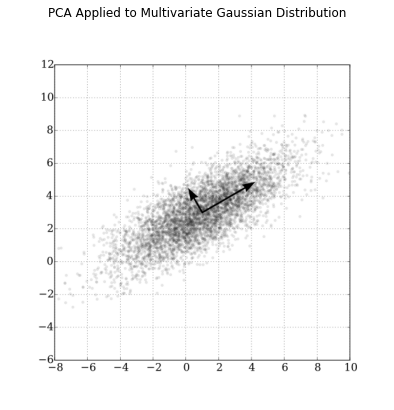

In [123]:
#@title
fig, ax = plt.subplots(figsize = (7, 7))
gaussian_pca = mpimg.imread('Autoencoders-Workshop/images/GaussianScatterPCA.png')
ax.imshow(gaussian_pca)
ax.axis('off')
ax.set_title('PCA Applied to Multivariate Gaussian Distribution')
plt.show()

[Image Source](https://en.wikipedia.org/wiki/Principal_component_analysis) <br> 

Multilayer perceptrons are probably the most basic class of neural networks. You are probably familiar with the below visualization for MLPs.


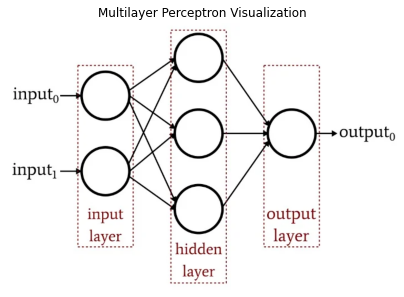

In [124]:
#@title
fig, ax = plt.subplots(figsize = (7, 7))
mlp = mpimg.imread('Autoencoders-Workshop/images/multilayer_perceptron.webp')
ax.imshow(mlp)
ax.axis('off')
ax.set_title('Multilayer Perceptron Visualization')
plt.show()

Another way to interpret MLPs is as a series of matrix multiplications and nonlinear activation functions. As an example, assume that we want to build the neural network from the visualization, where our input is two dimensions, our first and only hidden layer is three dimensions, and a output is one dimension. In addition, assume we have the following input, represented as a column vector.

$$
\begin{bmatrix}
1  \\
2
\end{bmatrix}
$$

In the transition from the input layer to the 3 dimensional hidden layer, we multiply this input by a 3 x 2 matrix, add a 3 x 1 bias term, and receive a three dimensional output vector. This vector is then fed into a non linear activation function, and now we have completed the transition to the hidden layer! Here is an example applied to our input, with a ReLU activation function (h) .

$$
h(x) = \max(0, x) \\
h( \ \begin{bmatrix}
2 & 1 \\
2 & -2 \\
3 & -1
\end{bmatrix}
\begin{bmatrix}
1  \\
2
\end{bmatrix} + 
 \begin{bmatrix}
1  \\
1 \\
1
\end{bmatrix}\ )  = 
h( \ \begin{bmatrix}
5 \\
-1 \\
2
\end{bmatrix}\ ) = 
\begin{bmatrix}
5 \\
0 \\
2
\end{bmatrix}\ 
$$

In the transition from the hidden layer to the 1 dimensional output layer, we will continue the same logic as before. We will multiply the previous output by a 1x3 matrix, add a 1x1 bias term. For the activation function, we will use the sigmoid (g), the most popular output layer for binary classification tasks. The sigmoid function "squishes" the input into a value in between 0 and 1. 

$$
g(x) = \frac{1}{1 + e^{-x}} \\
g( \ \begin{bmatrix} 
-1 & 2 & 3
\end{bmatrix}
\begin{bmatrix}
5 \\
0 \\
2
\end{bmatrix} +
1 \ ) = g(2) = 0.881
$$

To put mathematically, if x is an n-dimensional input vector, and we want an m-dimensional hidden layer with activation function h, we perform the following operation.

$$
x \in \mathbb{R}^{n}, \ \boldsymbol{W} \in \mathbb{R}^{m x n}, \ \boldsymbol{b} \in \mathbb{R}^{m} \\
h(\boldsymbol{W}x  + \boldsymbol{b}) 
$$

To obtain a multilayer perceptron, we "stack" these operations together via function composition. In other words, the output of the previous step will be the input for the next. We continue this until we reach the end of the network. Putting this all together, a multilayer percepton with *k* hidden layers and output layer *o* is defined mathematically below.

$$
f(x) = o(h_{k} ... ( h_{2}(\ \boldsymbol{W_{2}} (h_{1}( \ \boldsymbol{W_{1}}x + \boldsymbol{b_{1}} \ ) + \boldsymbol{b_{2}} \ ))...)
$$

To "learn", we first take the gradient of the cost function with respect to the parameters of the neural network ($\boldsymbol{W} \  \& \ \boldsymbol{b}$). We then update the parameters by taking the current netwoks' parameters and subtracting that by the gradient times some small step size. (If you are unfamilar with gradient descent and backpropogation, highly recommend [3Blue1Brown's series](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) on the basics of neural networks.
$$
\boldsymbol{W}^{i + 1} \leftarrow \boldsymbol{W}^{i} - \alpha * \nabla \boldsymbol{C}(\boldsymbol{W}^{i}) \\
\boldsymbol{b}^{i + 1} \leftarrow \boldsymbol{b}^{i} - \alpha * \nabla \boldsymbol{C}(\boldsymbol{b^{i}})
$$

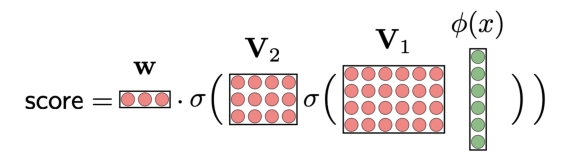

In [125]:
#@title 
fig, ax = plt.subplots(figsize = (10, 5))
mlp = mpimg.imread('Autoencoders-Workshop/images/neural_mm_visual.png')
ax.imshow(mlp)
ax.axis('off')
plt.show()


[Image Source](https://stanford-cs221.github.io/autumn2021-extra/modules/machine-learning/neural-networks.pdf)

Notice that when $m < n$ for a $\boldsymbol{W} \in \mathbb{R}^{m x n}$ weight matrix and $b \in \mathbb{R}^{m}$ bias vector, the operation $\boldsymbol{W}x  + b$ transforms the input vector into a lower dimensional representation. Thus, when the number of columns exceeds the number of rows, matrix multiplication is a convenient mathemtical operation to help perform dimensionality reduction. In addition, applying a nonlinear activation function in each hidden layer also allows neural networks to represent a wide variety of nonlinear functions. (This is because of the [Universal approximation theorem](https://towardsdatascience.com/neural-networks-and-the-universal-approximation-theorem-8a389a33d30a) for those interested)

Therefore, if we ensure that each hidden layer's dimension is lower than the previous one (this is good practice no matter what neural network you build), neural networks can be viewed as "non-linear data compressors". Ideally, when fully trained, points that belong in the same class should be clustered together in this lower dimensional space. This idea is the main motivation behind autoencoders, and because it is so important, we will demonstrate it through an example. <br> <br> 
Fashion MNIST is actually a labeled dataset, where the original purpose of it is to classify an image into one of ten categories (t-shirt, coat, sandal, etc.). We will design a simple MLP to do this, but to have a better understanding of neural networks as data compressors, the last hidden layer will have two dimensions. Thus, we can see exactly how the neural network transforms the data. 

In [126]:
# Load training data
trainset_pandas_full_1 = pd.read_csv('Autoencoders-Workshop/data/fashion-mnist_train_1.csv')
trainset_pandas_full_2 = pd.read_csv('Autoencoders-Workshop/data/fashion-mnist_train_2.csv')
trainset_pandas_full = pd.concat([trainset_pandas_full_1, trainset_pandas_full_2])
images_training = (trainset_pandas_full.iloc[:, 1:].to_numpy()/255)
labels_training = trainset_pandas_full.iloc[:, 0].to_numpy()

# Load testing data
testset_pandas_full = pd.read_csv('Autoencoders-Workshop/data/fashion-mnist_test.csv')
images_testing = (testset_pandas_full.iloc[:, 1:].to_numpy()/255)
labels_testing = testset_pandas_full.iloc[:, 0].to_numpy()

# Labels key
labels_dict = {0 : 'T-shirt/Top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 
               6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}


In [128]:
# Transform images and labels to pytorch tensors

images_training_tensor = torch.from_numpy(images_training).to(torch.float32).to(device_gpu)
labels_training_tensor = torch.from_numpy(labels_training).to(torch.long).to(device_gpu)
images_testing_tensor = torch.from_numpy(images_testing).to(torch.float32).to(device_gpu)
labels_testing_tensor = torch.from_numpy(labels_testing).to(torch.long).to(device_gpu)

In [129]:
# Seperate training images to training set and validation set

training_set = images_training_tensor[:50000]
training_labels = labels_training_tensor[:50000]
validation_set = images_training_tensor[50000:]
validation_labels = labels_training_tensor[50000:]

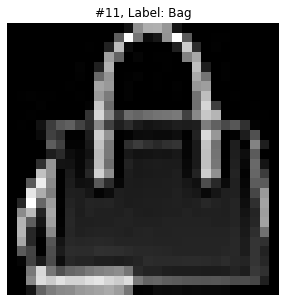

In [130]:
def visualize_fashion_mnist(i, images, labels, ax = None):
    
    '''
    Plot the image of the ith training example. 
    Images and labels must numpy arrays
    '''
    
    if ax is None:
        fig, ax = plt.subplots(figsize = (5, 5))
    
    image = images[i]
    label = labels[i]
    
    ax.imshow(image.reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f'#{i}, Label: {labels_dict[label]}')
    
    
visualize_fashion_mnist(11, images_training, labels_training)

In [131]:
torch.manual_seed(2023)

class Fashion_MNIST_MLP_Classifier(torch.nn.Module):
    
    '''
    Pytorch MLP Classifier for the Fashion MNIST Dataset
    
    hidden_layer_dims - list of integers representing dimensions of hidden layers
    activation_functions - list of Pytorch activation functions to apply in each hidden layer. Must be 
    the same length as hidden_layer_dims
    input_dim - dimension of input, default to 784 (for 28 x 38 image)
    output_dim - dimension of output, default to 10 (for 10 classes)
    '''
    
    def __init__(self, hidden_layer_dims, activation_functions, input_dim = 784, output_dim = 10):
        
        super().__init__()
        
        # Make first hidden layer
        hidden_layers = []
        hidden_layers.append(torch.nn.Linear(in_features = input_dim, out_features = hidden_layer_dims[0], bias = True))
        hidden_layers.append(activation_functions[0])
        
        # Make rest of hidden layers
        for i in range(len(hidden_layer_dims) - 1):
            
            hidden_layers.append(torch.nn.Linear(in_features = hidden_layer_dims[i], out_features = hidden_layer_dims[i + 1], bias = True))
            hidden_layers.append(activation_functions[i + 1])
           
        # Stack the hidden layers together with the Sequential function
        self.model_hidden_layers = torch.nn.Sequential(*hidden_layers)
        
        # Make output layer
        self.output_layer = torch.nn.Linear(in_features = hidden_layer_dims[-1], out_features = output_dim, bias = True)
        
        
    def forward(self, data):
        
        # Forward propogation. Outputs unnormalized class probabilties and values of final input layer
        hidden_output = self.model_hidden_layers(data)
        final_output = self.output_layer(hidden_output)
        
        return hidden_output, final_output
                                 


In [132]:
model_supervised = Fashion_MNIST_MLP_Classifier([392, 196, 98, 2], 
                                                [torch.nn.ReLU(), torch.nn.ReLU(), torch.nn.ReLU(), torch.nn.PReLU()]).to(device_gpu)

In [133]:
def get_mnist_accuracy(final_output, labels):
    
    # Class accuracy calculater
    return torch.mean((torch.argmax(final_output, dim =1) == labels).to(torch.float32)).item()

In [134]:
# Hyperparameters for training

num_epochs = 300
batch_size = 10000
training_size = training_set.size()[0]
loss_func = torch.nn.CrossEntropyLoss(reduction = 'mean')
optimizer = torch.optim.Adam(model_supervised.parameters(), lr = 0.001, weight_decay = 0.005)

In [135]:
# Will record (loss, accuracy) for each of the epochs
train_metrics_list = []
valid_metrics_list = []

for i in range(num_epochs): 
    
    batch_start = 0
    
    train_loss = []
    train_accuracy = []
    
    model_supervised.train()
    
    while batch_start < training_size: 
        
        batch_end = batch_start + batch_size
        
        # Get batch and feed into network
        inputs = training_set[batch_start:batch_end]
        labels = training_labels[batch_start:batch_end]
        
        hidden_output, final_output = model_supervised(inputs)
        loss = loss_func(final_output, labels)
        
        # Get training loss and accuracy 
        train_loss.append(loss.item() * inputs.size()[0])
        train_accuracy.append(get_mnist_accuracy(final_output, labels) * inputs.size()[0])
        
        # Update parameters with backpropogation and gradient descent 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_start = batch_end
    
    model_supervised.eval() 
    
    # Turn off gradient caclulations as we don't need them for evaulation
    with torch.no_grad(): 
        
        # Obtain metrics for validation set
        hidden_output_eval, final_output_eval = model_supervised(validation_set)

        validation_loss = loss_func(final_output_eval, validation_labels).item()
        validation_accuracy = get_mnist_accuracy(final_output_eval, validation_labels)
    
    epoch_train_loss = np.sum(train_loss)/training_size
    epoch_train_accuracy = np.sum(train_accuracy)/training_size

    valid_metrics_list.append((validation_loss, validation_accuracy))
    train_metrics_list.append((epoch_train_loss, epoch_train_accuracy))
    
    if i % 20 == 0 or i == num_epochs - 1:
    
        # Print accuracies and losses for every epoch

        status = f"Epoch: {i} \nValidation Loss: {validation_loss} \nTrain Loss: {epoch_train_loss} \n\
Validation Accuracy: {validation_accuracy} \nTrain Accuracy: {epoch_train_accuracy} \n"

        print(status)
        

Epoch: 0 
Validation Loss: 2.2891182899475098 
Train Loss: 2.3252820014953612 
Validation Accuracy: 0.19689999520778656 
Train Accuracy: 0.12609999775886535 

Epoch: 20 
Validation Loss: 1.208174228668213 
Train Loss: 1.2056388854980469 
Validation Accuracy: 0.5518999695777893 
Train Accuracy: 0.5474799990653991 

Epoch: 40 
Validation Loss: 1.0002048015594482 
Train Loss: 0.9816213011741638 
Validation Accuracy: 0.6481999754905701 
Train Accuracy: 0.6376599669456482 

Epoch: 60 
Validation Loss: 0.8520474433898926 
Train Loss: 0.8196719527244568 
Validation Accuracy: 0.7076999545097351 
Train Accuracy: 0.7051599740982055 

Epoch: 80 
Validation Loss: 0.7288268804550171 
Train Loss: 0.6764922261238098 
Validation Accuracy: 0.7674999833106995 
Train Accuracy: 0.784499979019165 

Epoch: 100 
Validation Loss: 0.627555251121521 
Train Loss: 0.5872902154922486 
Validation Accuracy: 0.8073999881744385 
Train Accuracy: 0.8135199666023254 

Epoch: 120 
Validation Loss: 0.61895751953125 
Train 

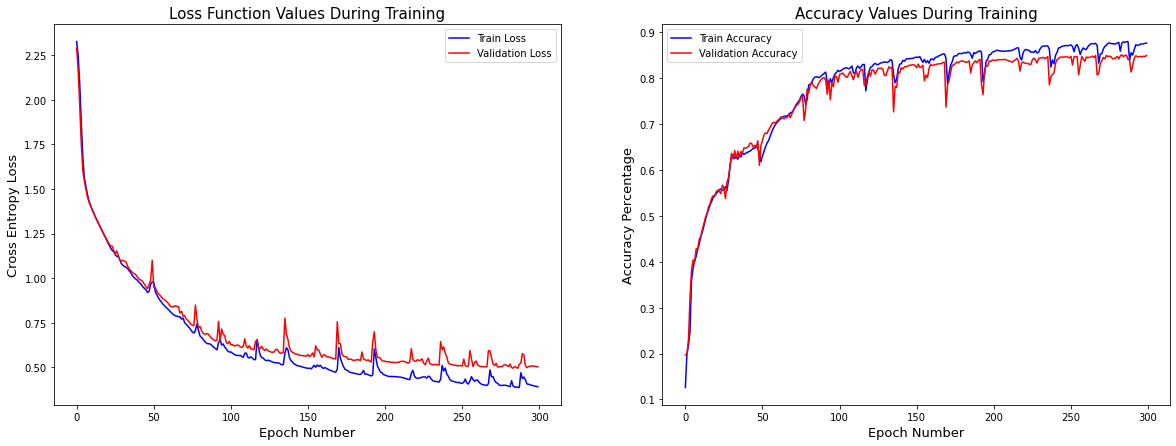

In [93]:
# Plot training and validation loss and accuracy for each epoch

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 7))

ax[0].plot(np.arange(num_epochs), [x[0] for x in train_metrics_list], '-', color = 'blue', label = 'Train Loss')
ax[0].plot(np.arange(num_epochs), [x[0] for x in valid_metrics_list], '-', color = 'red', label = 'Validation Loss')
ax[0].set_title('Loss Function Values During Training', fontsize = 15)
ax[0].set_xlabel('Epoch Number', fontsize = 13)
ax[0].set_ylabel('Cross Entropy Loss', fontsize = 13)
ax[0].legend()

ax[1].plot(np.arange(num_epochs), [x[1] for x in train_metrics_list], '-', color = 'blue', label = 'Train Accuracy')
ax[1].plot(np.arange(num_epochs), [x[1] for x in valid_metrics_list], '-', color = 'red', label = 'Validation Accuracy')
ax[1].set_title('Accuracy Values During Training', fontsize = 15)
ax[1].set_xlabel('Epoch Number', fontsize = 13)
ax[1].set_ylabel('Accuracy Percentage', fontsize = 13)
ax[1].legend()

In [94]:
with torch.no_grad():
    hidden_test, output_test = model_supervised(images_testing_tensor)
    
print('Testing Accuracy:', get_mnist_accuracy(output_test, labels_testing_tensor))

Testing Accuracy: 0.8549000024795532


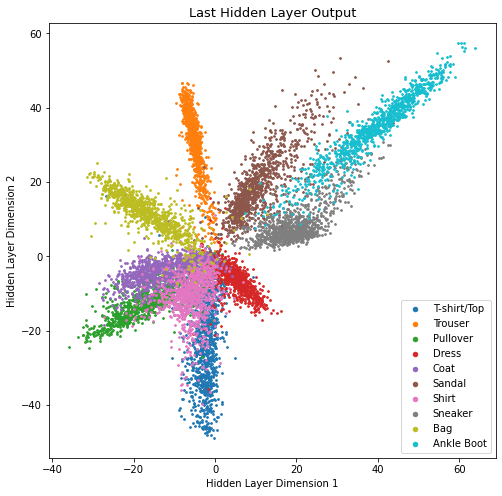

In [95]:
# Plot the last hidden layer's output using the testing set's input
hidden_df = pd.DataFrame(hidden_test)
hidden_df['label'] = labels_testing_tensor.to(device_cpu)

fig, ax = plt.subplots(figsize = (8, 8))

for label, group in hidden_df.groupby('label'):
    
    ax.scatter(group[0], group[1], 3,  label = labels_dict[label])
    
legend = ax.legend(fontsize = 10)

for k in range(10):
    legend.legendHandles[k]._sizes = [20]
    
ax.set_title('Last Hidden Layer Output', fontsize = 13)
ax.set_xlabel('Hidden Layer Dimension 1', fontsize = 10)
ax.set_ylabel('Hidden Layer Dimension 2', fontsize = 10)
plt.show()

Clustered together, just like we expected! Now of course, if we have access to labels, we could just train a network in a supervised manner. Then for our search function, we could just take the output of the last hidden layer, and utilize that for finding nearest neighbors. However, for many situations, we don't have access to any labels. Then how do we train a neural network in a completely unsupervised matter? This is where autoencoders come in! 

## Autoencoders for Unsupervised Dimensionality Reduction

In the previous section, we saw how deep learning can be seen as a nonlinear data compressors, where we are able to transform a complex, high dimensional feature space into a lower dimensional simpler space. However, as you are probably aware, dimensionality reduction is mostly utilized as an unsupervised learning task, so how to do we train a neural network without labels? <br> 

The main idea of autoencoders is to build a neural network with two components. The first part is called the **encoder**. The encoder's job is to compress the original data point to a lower dimensional representation, identical to what we have seen before. In the case of a multilayer perceptron, the encoder's hidden layers, and thus weight matrices and biases in the encoder, should always have an output dimension less than the input dimension. Or put mathematically, for all $\boldsymbol{W} \in \mathbb{R}^{m x n}, \boldsymbol{b} \in \mathbb{R}^{m}$ in the encoder network, $m < n$. <br> 

The second part is called the **decoder**. The decoder's job is to take the final layer output of the encoder and then "reconstruct" the original image via a sequence of hidden layers. That is, take the lower dimensional input transform it back into the higher dimensional space with a neural network. This final result of this transformation should match the original image as closely as possible. <br>

In the case of a multilayer perceptron, the decoder's hidden layers, and thus weight matrices and biases in the decoder, should always have an output dimension greater than the input dimension. Or put mathematically, for all $\boldsymbol{W} \in \mathbb{R}^{m x n}, \boldsymbol{b} \in \mathbb{R}^{m}$ in the decoder network, $m > n$. <br> 

Like we saw in our previous example, similar items in the dataset should be clustered together in the lower dimensional space, as the decoder should be able to reconstruct "close" items in the lower dimensional space into a nearly identical output. Therefore, for our task, after training, we can first input our images into the encoder. Then, we take the encoder's output and find similar objects to it via a simple distance metric like Euclidean distance. 

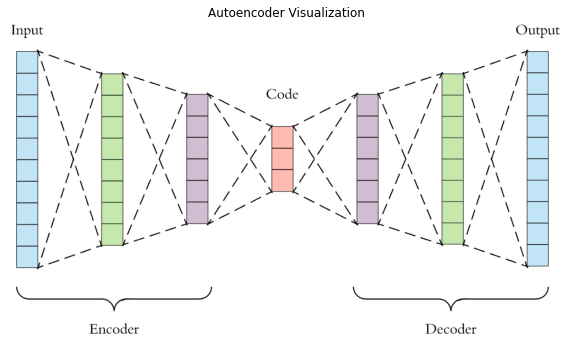

In [96]:
#@title 
fig, ax = plt.subplots(figsize = (10, 7))
auto_mlp = mpimg.imread('Autoencoders-Workshop/images/autoencoder.png')
ax.imshow(auto_mlp)
ax.axis('off')
ax.set_title('Autoencoder Visualization')
plt.show()

[Image Source](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798)

Now, how do we train train this? Remember, because our goal is to "reconstruct" the original image, both the input of the encoder and the output of the decoder will have the same dimension. In addition, because the output is continuous (meaning there are no "classes"), we can see this as a regression problem, where the input is the original image and the output is trying to match it. Thus, we can utilize the mean squared error cost function to train the autoencoder. <br> 

To put this mathematically, if $x_{i}$ is an image in our dataset and $f_{E, D}(x)$ is our autoencoder, our cost function will be: 

$$
\frac{1}{n} \sum_{i = 1}^{n} ||x_{i} - f_{E, D}(x_{i})||_{2}^{2}
$$

Once we are done training, we just input the image into just the encoder $f_{E}(x)$ and use the lower dimensional output for our task. 

## Improving Autoencoders' Performance

The architecture we described earlier is called an undercomplete autoencoder. However, these types of autoencoders are prone to just learn an ultra fancy version of the identity function. Therefore, instead of learning any useful lower dimension representation, the network merely learns how to copy the input. Thus, we need to add some modifications if we want to use an autoencoder for our task. <br> 

**1. Denoising Autoencoder** <br>

Despite their name, denoising autoencoders do not involve drastically changing the autoencoder architecture. Rather we will corrupt the input with some sort of noise. Then, we train the neural network to reconstruct the original image. Thus, our cost function is modified to what it is below, where $g$ represents the corrupting procedure 

$$
\frac{1}{n} \sum_{i = 1}^{n} ||x_{i} - f_{E, D}(g(x_{i}))||_{2}^{2}
$$

The simplest "corrupting" function is Gaussian noise, where a random draw from a Gaussian distrubution is added to each pixel value($g(x_{i}) = x_{i} + y_{i}, \ y_{i} \sim N(0, \sigma^{2})$). The variance of the distribution is typically small.  <br> 

Intuitively, denoising autoencoders "teach" the network to reconstruct the original image rather than merely copy it. Therefore, the network must learn more valuable feature representations in order to denoise the original image. 

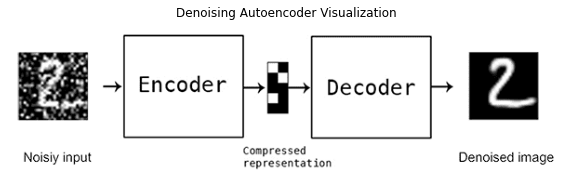

In [97]:
#@title
fig, ax = plt.subplots(figsize = (10, 7))
mlp = mpimg.imread('Autoencoders-Workshop/images/denoising_autoencoder.png')
ax.imshow(mlp)
ax.axis('off')
ax.set_title('Denoising Autoencoder Visualization')
plt.show()

[Image Source](https://pyimagesearch.com/2020/02/24/denoising-autoencoders-with-keras-tensorflow-and-deep-learning/) <br>

**2. Sparse Autoencoder** <br>

You are probably familar with the LASSO or L1 penalty, which is stated below.

$$
\lambda ||w||_{1} = \lambda \sum_{j = 1}^{p} |w_{i}|
$$

When added with a typical cost function, the LASSO penalty helps push unimportant weights to zero. This not only makes our model simpler, but helps reduce overfitting by removing unimportant correlations. <br> 

In our case, if two objects are similar, we want the same dimensions in the encoder output vectors to "activate" (be a number not equal to zero) and "deactivate" (be a number equal to zero). Not only is this lower dimensional feature space simpler, but identifying similar objects becomes much easier, as ideally, they will have the same non-zero dimensions. <br>

Therefore, because we want to push some of the encoder output's dimensions to zero, we can use the LASSO penalty in our cost function. Thus, if we want to combine both a sparse and denoising autoencoder, our cost function now becomes: 

$$
\frac{1}{n} \sum_{i = 1}^{n}(||x_{i} - f_{E, D}(g(x_{i}))||_{2}^{2} + \lambda ||f_{E}(x_{i})||_{1})
$$

## Training our Autoencoder

In [98]:
# Add gaussian noise to our image. Apply min-max scaling to make sure new values are in between 0 and 1

unnormalized_images = images_training + np.random.normal(loc = 0, scale = 0.1, size = images_training.shape)
minimums = np.min(unnormalized_images, axis = 1).reshape(-1, 1)
maximums = np.max(unnormalized_images, axis = 1).reshape(-1, 1)
normalized_images_training = (unnormalized_images - minimums)/(maximums - minimums)

normalized_images_training_tensor = torch.from_numpy(normalized_images_training).to(torch.float32).to(device_gpu)

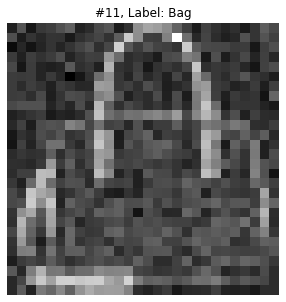

In [99]:
visualize_fashion_mnist(11, normalized_images_training, labels_training)

In [101]:
torch.manual_seed(2023)

class Fashion_MNIST_MLP_Autoencoder(torch.nn.Module):
    
    '''
    Builds MLP autoencoder for Fashion MNIST Dataset
    
    encoder_layer_dims - list of integers representing dimensions of encoder's hidden layers. Last value of the list represents the 
    dimension of the encoder output
    encoder_activations - list of Pytorch activations functions to apply to each of the encoder's hidden layers. List must be the 
    same length as encoder_layer_dims
    decoder_layer_dims - list of integers representing dimensions of decoder's hidden layers. This list does not include the output dimension
    decoder_activations - list of Pytorch activations functions to apply to each of the decoder's hidden layers. List must be the 
    same length as decoder_layer_dims
    in_out_dim - integer represting dimension of the input and output. Defaults to 784. 
    '''
    
    def __init__(self, encoder_layer_dims, encoder_activations, decoder_layer_dims, decoder_activations, 
                 output_activation, in_out_dim = 784):
        
        super().__init__()
        
        # Build the first layer of encoder
        encoder_layers = []
        encoder_layers.append(torch.nn.Linear(in_features = in_out_dim, out_features = encoder_layer_dims[0], bias = True))
        encoder_layers.append(encoder_activations[0])
        
        # Build rest of the layers of encoder
        for i in range(len(encoder_layer_dims) - 1):
            
            encoder_layers.append(torch.nn.Linear(in_features = encoder_layer_dims[i], out_features = encoder_layer_dims[i + 1], bias = True))
            encoder_layers.append(encoder_activations[i + 1])
        
        # Stack the encoder layers
        self.encoder = torch.nn.Sequential(*encoder_layers)
        
        # Build the first layer of decoder
        decoder_layers = []
        decoder_layers.append(torch.nn.Linear(in_features = encoder_layer_dims[-1], out_features = decoder_layer_dims[0], bias = True))
        decoder_layers.append(decoder_activations[0])
        
        # Build rest of the layers of decoder
        for i in range(len(decoder_activations) - 1):
            
            decoder_layers.append(torch.nn.Linear(in_features = decoder_layer_dims[i], out_features = decoder_layer_dims[i + 1], bias = True))
            decoder_layers.append(decoder_activations[i + 1])
        
        # Build output layer
        decoder_layers.append(torch.nn.Linear(in_features = decoder_layer_dims[-1], out_features = in_out_dim, bias = True))
        decoder_layers.append(output_activation)
        
        # Stack the decoder layers
        self.decoder = torch.nn.Sequential(*decoder_layers)
        
    def encode(self, data):
        # Forward propogation for the encoder
        return self.encoder(data)
    
    def decode(self, encoded):
        # Forward propogation of the decoder 
        return self.decoder(encoded)
        
    def forward(self, data):
        # Forward propogation for entire network 
        encoded = self.encode(data)
        decoded = self.decode(encoded)
        
        return encoded, decoded
    
autoencoder = Fashion_MNIST_MLP_Autoencoder([196, 100, 50], [torch.nn.ReLU(), torch.nn.ReLU(), torch.nn.ReLU()], [100, 196], 
                                            [torch.nn.ReLU(), torch.nn.ReLU()], torch.nn.ReLU(), in_out_dim = 784).to(device_gpu)

In [102]:
corrupted_training_set = normalized_images_training_tensor[:50000]
corrupted_validation_set = normalized_images_training_tensor[50000:]

In [103]:
mse_loss = torch.nn.MSELoss(reduction = 'sum')

def sparse_autoencoder_loss(encoded, decoded, y, lam):
    
    # Sparse encoder loss with LASSO penalty
    mse = 1/y.size()[0] * mse_loss(decoded, y)
    penalty = lam/y.size()[0] * torch.sum(torch.abs(encoded))
    
    return mse + penalty

# Hyperparameters for autoencoder
ae_num_epochs = 360
ae_batch_size = 10000
ae_training_size = corrupted_training_set.size()[0]
ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)
lam = 0.001

In [104]:
# Training and validation loss for training
ae_training_loss = []
ae_validation_loss = []


for i in range(ae_num_epochs):
    
    train_epoch_loss = []
    
    autoencoder.train()
    ae_batch_start = 0
    
    while ae_batch_start < ae_training_size:
        
        ae_batch_end = ae_batch_start + ae_batch_size
        
        # Get batch of corrupted input and true image
        corrupted_batch = corrupted_training_set[ae_batch_start:ae_batch_end]
        training_batch = training_set[ae_batch_start:ae_batch_end]
        
        # Run through autoencoder and calculate loss
        encoded, decoded = autoencoder(corrupted_batch)
        ae_loss = sparse_autoencoder_loss(encoded, decoded, training_batch, lam)
        
        train_epoch_loss.append(ae_loss.item() * corrupted_batch.size()[0])
        
        # Backpropogation and gradient descent 
        ae_optimizer.zero_grad()
        ae_loss.backward()
        ae_optimizer.step()
        
        ae_batch_start = ae_batch_end
        
    autoencoder.eval()
    
    with torch.no_grad():
        
        # Input validation set into autoencoder and obtain metrics 
        val_encoded, val_decoded = autoencoder(corrupted_validation_set)
        
        ae_val_loss = sparse_autoencoder_loss(val_encoded, val_decoded, validation_set, lam).item()
        
    ae_epoch_training_loss = np.sum(train_epoch_loss)/ae_training_size
    
    ae_training_loss.append(ae_epoch_training_loss)
    ae_validation_loss.append(ae_val_loss)
    
    # Print out metrics for every 20 epochs 
    if i % 20 == 0 or i == ae_num_epochs - 1:
        
        ae_status = f'Epoch {i}: \nValidation Loss: {ae_val_loss} \nTraining Loss: {ae_epoch_training_loss}\n' 
        print(ae_status)
    
    
        
    

Epoch 0: 
Validation Loss: 130.26422119140625 
Training Loss: 147.13356018066406

Epoch 20: 
Validation Loss: 57.85505676269531 
Training Loss: 58.37641983032226

Epoch 40: 
Validation Loss: 34.92014694213867 
Training Loss: 34.86571197509765

Epoch 60: 
Validation Loss: 29.558273315429688 
Training Loss: 29.36285972595215

Epoch 80: 
Validation Loss: 27.529813766479492 
Training Loss: 27.32572250366211

Epoch 100: 
Validation Loss: 26.070920944213867 
Training Loss: 25.790863037109375

Epoch 120: 
Validation Loss: 25.011905670166016 
Training Loss: 24.75325126647949

Epoch 140: 
Validation Loss: 24.34699821472168 
Training Loss: 24.13031768798828

Epoch 160: 
Validation Loss: 23.88648796081543 
Training Loss: 23.59737319946289

Epoch 180: 
Validation Loss: 23.3936767578125 
Training Loss: 23.132073211669923

Epoch 200: 
Validation Loss: 23.00782012939453 
Training Loss: 22.78697090148926

Epoch 220: 
Validation Loss: 22.71218490600586 
Training Loss: 22.43697738647461

Epoch 240: 
Val

## Fashion Recommender

In [105]:
with torch.no_grad():
    encoded_search, decoded_search = autoencoder(normalized_images_training_tensor)

In [106]:
def fashion_recommender(i, encoded_search, images, labels, top_k = 10):
    
    '''
    Fashion Recommendation System. Input an image, and will recommend top_k most similar items to that image based on encodings. 
    
    i - integer representing the ith image in the array images
    encoded_search - Pytorch encodings of entire image database
    images- numpy array of the original image dataset. Used to display results
    labels - numy array of the original image labels. Used to display results.
    top_k - find top_k most similar results
    '''
    # FOr plotting results
    if top_k < 5:
        num_cols = top_k 
        num_rows = 1
        
    else: 
        num_cols = 5
        num_rows = (top_k - 1)// 5 + 1
    
    # Plot original image of the user image
    visualize_fashion_mnist(i, images, labels)
        
    fig, ax = plt.subplots(num_rows, num_cols, figsize = (4 * num_cols, 4 * num_rows))
    
    with torch.no_grad():
        # Find most similar items based on encodings. 
        norms = torch.norm((encoded_search - encoded_search[i]), dim = 1)
        recommended = torch.reshape(torch.argsort(norms)[1:(top_k + 1)], (num_rows, num_cols))
            
    
    for row in range(num_rows):
        for col in range(num_cols):
            # Plot results 
            if num_rows == 1:
                ax_number = ax[col]
            else:
                ax_number = ax[row, col]
                
            visualize_fashion_mnist(recommended[row, col], images, labels, ax = ax_number)

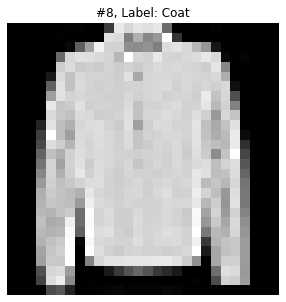

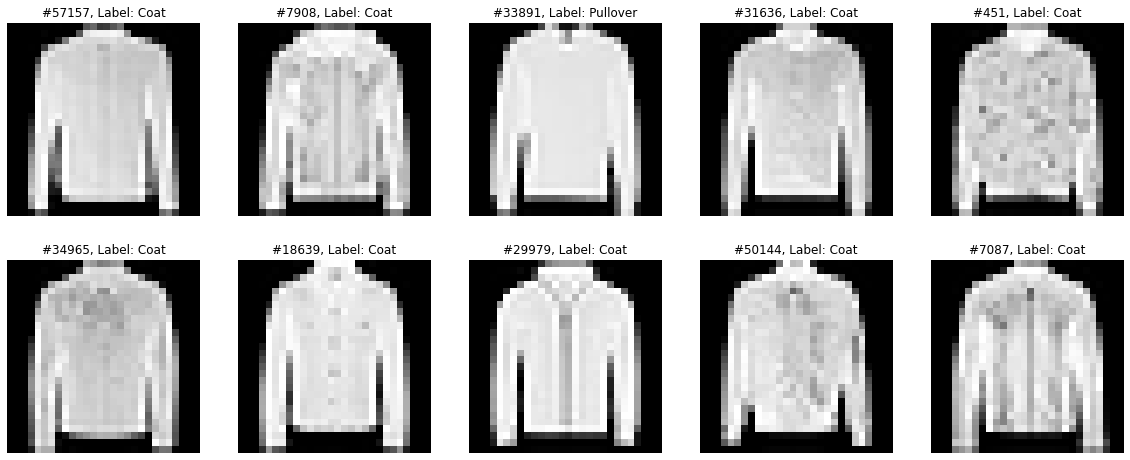

In [108]:
fashion_recommender(8, encoded_search, images_training, labels_training, 10)


In [114]:
def visualize_autoencoder(i, corrupted_inputs, encoded, decoded, encoded_hm_dim):
    
    '''
    Displays corrupted image, heatmap of the encoder's output, and the decoder's output
    '''
    fig, ax = plt.subplots(1, 3, figsize = (30, 10))
    
    ax[0].imshow(corrupted_inputs[i].reshape(28, 28), cmap = 'gray')
    ax[0].axis('off')
    ax[0].set_title(f'Corrupted Input #{i}', fontsize = 20)
    
    ax[1].imshow(encoded[i].reshape(encoded_hm_dim[0], encoded_hm_dim[1]), cmap = 'Greens')
    ax[1].axis('off')
    ax[1].set_title(f'Encoded Representation #{i}', fontsize = 20)
    
    ax[2].imshow(decoded[i].reshape(28, 28), cmap = 'gray')
    ax[2].axis('off')
    ax[2].set_title(f'Decoded Output #{i}', fontsize = 20)
                              
normalized_cpu = normalized_images_training_tensor.to(device_cpu)    
encoded_cpu = encoded_search.to(device_cpu)
decoded_cpu = decoded_search.to(device_cpu)   

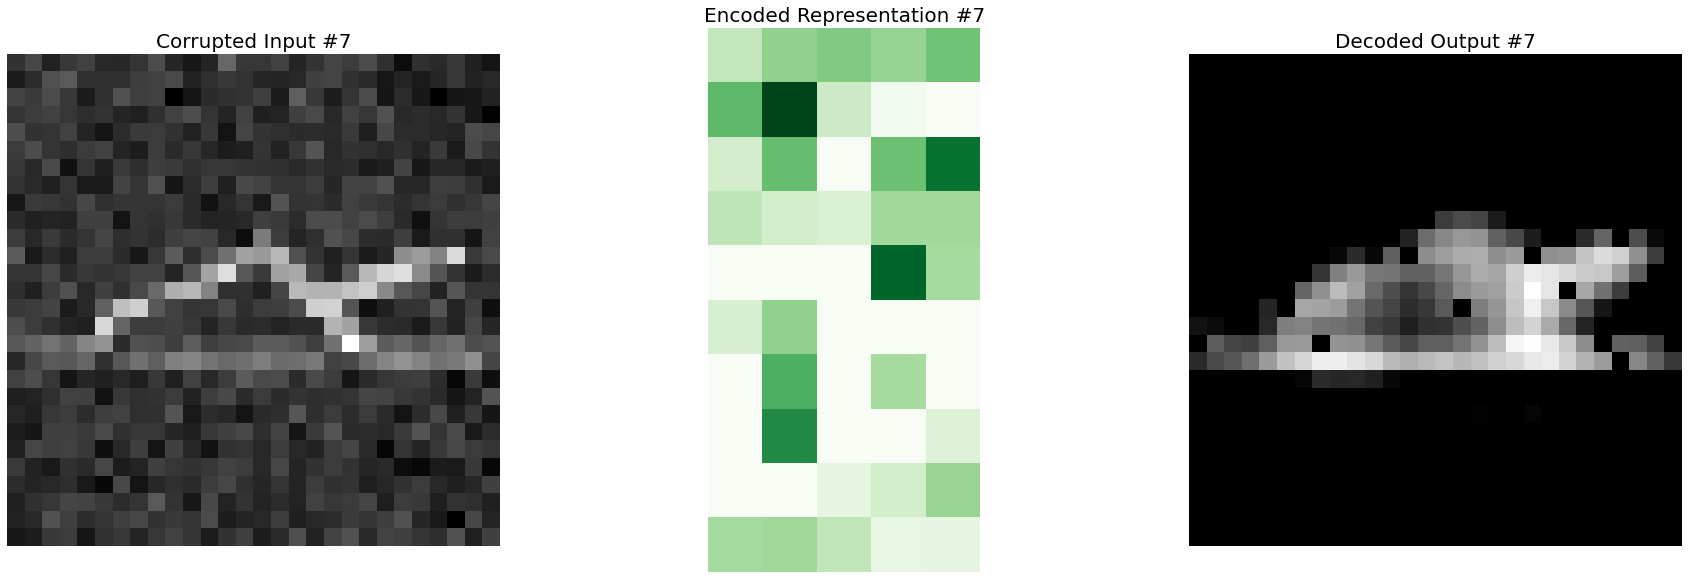

In [115]:
visualize_autoencoder(7, normalized_cpu, encoded_cpu, decoded_cpu, (10, 5))

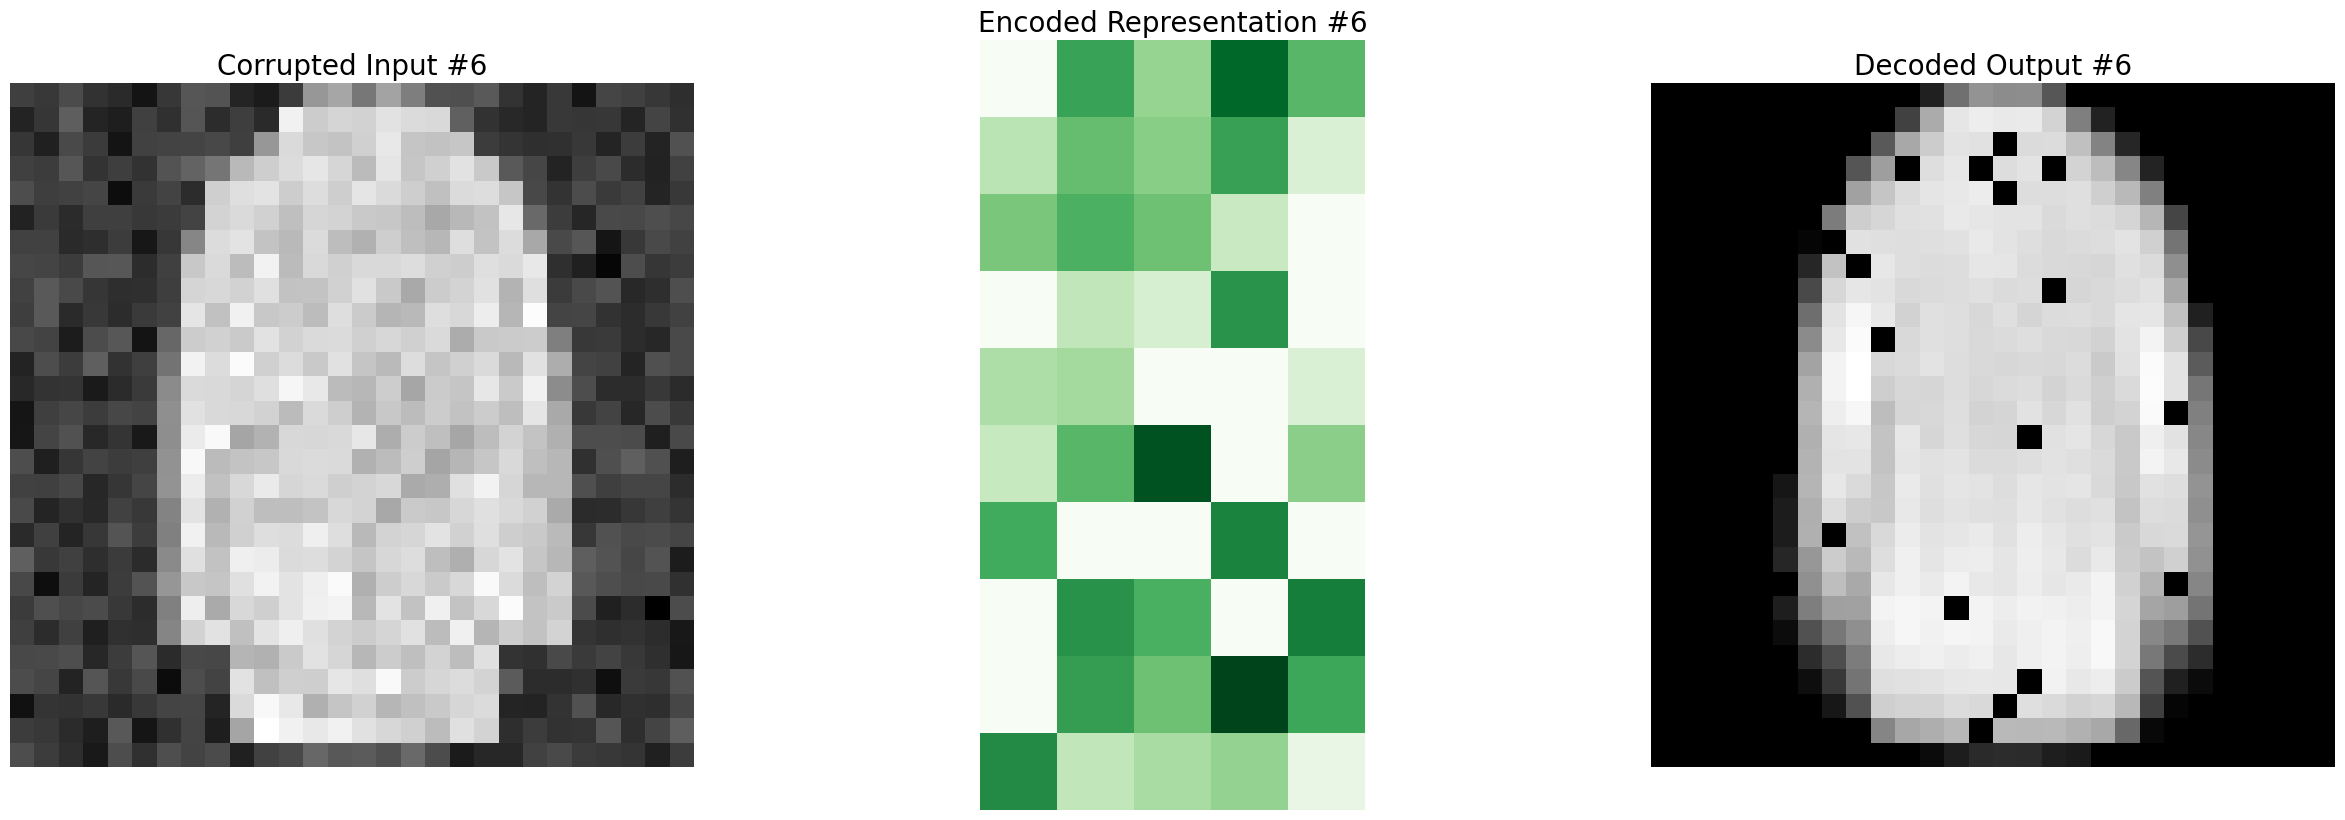

In [ ]:
visualize_autoencoder(6, normalized_images_training_tensor, encoded_search, decoded_search, (10, 5))

Now, admittely, it turns out you can get pretty good results by using the Eucidean distance on the raw Fashion MNIST image. However, in our case, we reduced the dimensionity of the search by 15x, thus making the recommendation engine 15x faster by using the autoencoder. Now, imagine the case of Pinterest, which often deals with millions images each having millions of pixels, a simple metric on the raw image will not suffice. As we saw in the bunny example, the Euclidean distance was not a great metric for color images. Therefore, they must rely on an autoencoder to reduce the dimensionality of the input while maintaining accuracy.

This concludes our workshop.